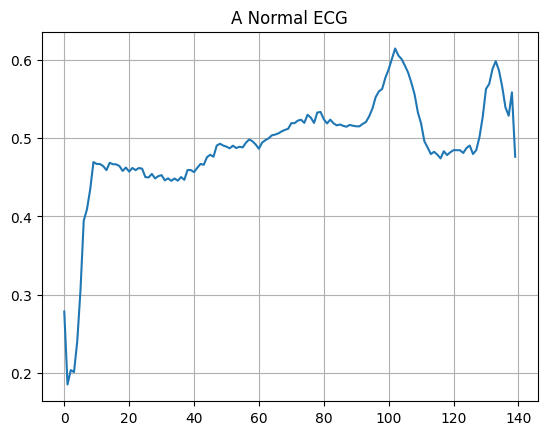

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values

# The last element contains the labels
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=0
)


min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)


# You will train the autoencoder using only the normal rhythms
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

# Plot a normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()


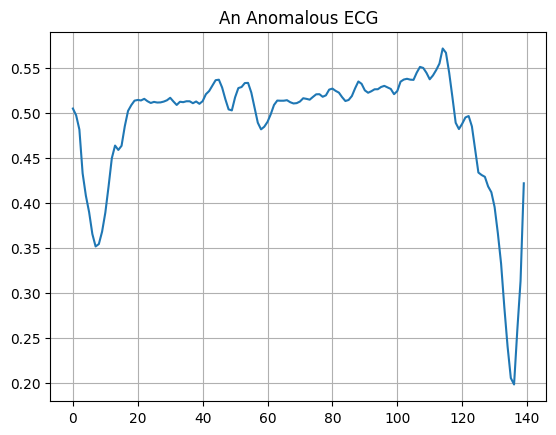

Epoch 1/20
5/5 [==============================] - 1s 52ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 11/20
5/5 [============

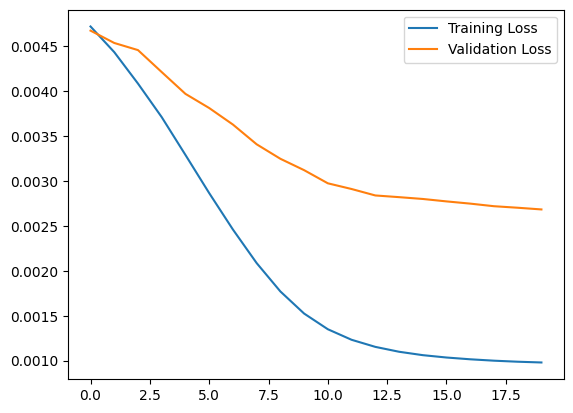

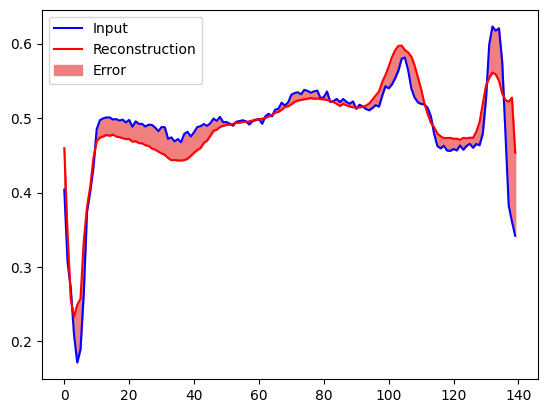

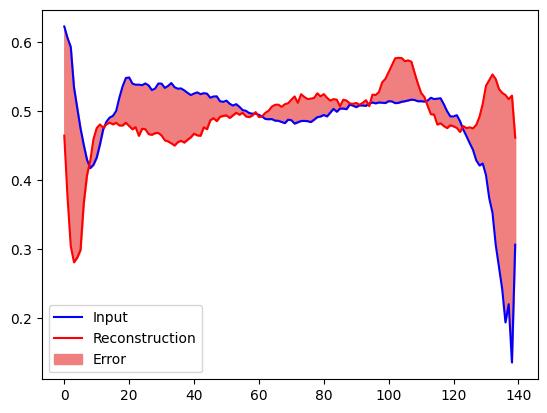

73/73 [==============================] - 0s 1ms/step


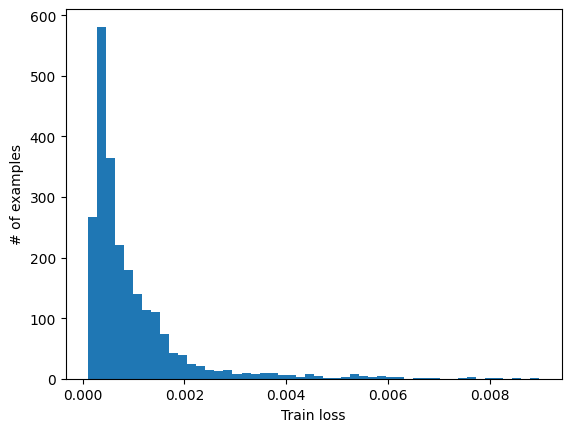

Threshold:  0.002038482530999752
13/13 [==============================] - 0s 1ms/step


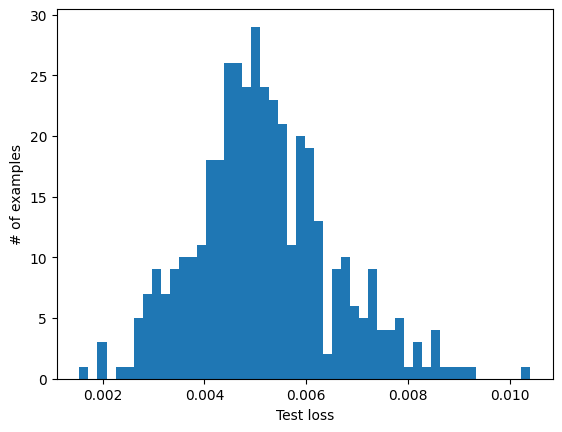

32/32 [==============================] - 0s 1ms/step
Accuracy = 0.948
Precision = 0.992619926199262
Recall = 0.9180887372013652


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

# Define the encoder
encoder = tf.keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu")
])

# Define the decoder
decoder = tf.keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(140, activation="sigmoid")
])

# Define the autoencoder
input_ecg = tf.keras.Input(shape=(140,))
encoded = encoder(input_ecg)
decoded = decoder(encoded)
autoencoder = tf.keras.Model(inputs=input_ecg, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs=20,
                          batch_size=512,
                          validation_data=(test_data, test_data),
                          shuffle=True)

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Functions to plot reconstruction error
def plot_reconstruction_error(model, data, example_index):
    encoded_data = encoder(data).numpy()
    decoded_data = decoder(encoded_data).numpy()

    plt.plot(data[example_index], 'b')
    plt.plot(decoded_data[example_index], 'r')
    plt.fill_between(np.arange(140), decoded_data[example_index], data[example_index], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

# Plot reconstruction error for a normal ECG
plot_reconstruction_error(autoencoder, normal_test_data, 0)

# Plot reconstruction error for an anomalous ECG
plot_reconstruction_error(autoencoder, anomalous_test_data, 0)

# Detect anomalies
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("# of examples")
plt.show()

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mse(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("# of examples")
plt.show()


def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mse(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    labels = labels.astype(bool)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    print("Accuracy = {}".format(accuracy))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))


preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)


In [6]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Fit KMeans on the normal ECG data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(normal_train_data)


def find_distances(data, kmeans_model):
    distances = kmeans_model.transform(data)
    return np.min(distances, axis=1)


threshold = 0.5


# Predict anomalies on test data based on the distance
test_distances = find_distances(test_data, kmeans)
preds = test_distances > threshold


preds = preds.astype(bool)


def print_stats(predictions, labels):
    labels = labels.astype(bool)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    print("Accuracy = {}".format(accuracy))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))


print_stats(preds, test_labels.astype(bool))


/Users/wwami/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy = 0.044
Precision = 0.08705357142857142
Recall = 0.06655290102389079


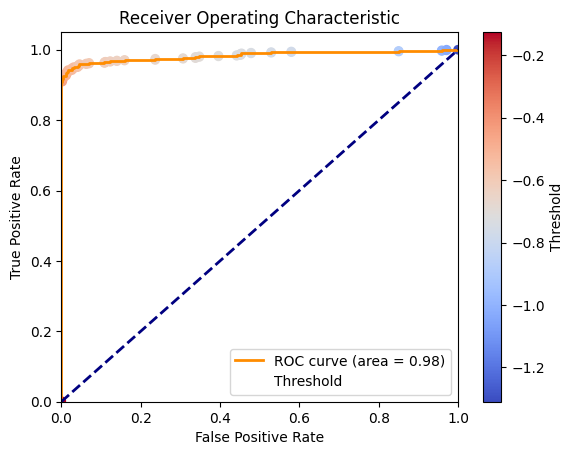

In [12]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt


# test_distances = find_distances(test_data, kmeans)

# # The 'test_distances' can be considered as anomaly scores (higher means more anomalous)
# anomaly_scores = -test_distances

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)
# roc_auc = auc(fpr, tpr)

# # Plot of a ROC curve for a specific class
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

test_distances = find_distances(test_data, kmeans)

# The 'test_distances' can be considered as anomaly scores (higher means more anomalous)
anomaly_scores = -test_distances

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(fpr, tpr, c=thresholds, cmap='coolwarm', label='Threshold')
plt.colorbar(label='Threshold')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [8]:
distance = (fpr**2 + (1-tpr)**2)**0.5  # The distance from the top-left corner
optimal_idx = np.argmin(distance)  # Find the index of the smallest distance
optimal_threshold = thresholds[optimal_idx]  # Find the optimal threshold based on this index

print("Optimal Threshold:", -optimal_threshold)

Optimal Threshold: 0.5419621340994105


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def find_distances(data, kmeans_model):
    distances = kmeans_model.transform(data)
    return np.min(distances, axis=1)


test_distances = find_distances(test_data, kmeans)


anomaly_scores = -test_distances

# Reminder: In this context, a more negative score indicates a higher likelihood of being an anomaly
preds = anomaly_scores > optimal_threshold


preds = preds.astype(bool)


def print_stats(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    print(f"Accuracy = {accuracy:.4f}")
    print(f"Precision = {precision:.4f}")
    print(f"Recall = {recall:.4f}")


print_stats(preds, test_labels.astype(bool))


Accuracy = 0.9570
Precision = 0.9772
Recall = 0.9488
